# Multioutput Gaussian Process test 1, applied to Mocap data-set

Some previous definitions and library invocations needed to process data

In [36]:
%pylab inline
import numpy as np
import pylab as pb
import GPy
import urllib


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Fisrt is necesary to retrieve the data from the mocap database located at: http://mocap.cs.cmu.edu/, there one can encounter different datasets of human motion on different situations. There are several files describing the motion of an skeleton, for the purpose of this implementation one can use the .amc files, which specifies the angle of each joint defined by the skeleton for an specific time stamp or frame. The following code retrieves the data of an specific movement previously defined by the user, for that objective first one have to identify the desired motion in this case, a soccer player kicking a ball: http://mocap.cs.cmu.edu/search.php?subjectnumber=10&trinum=6

Then is necesary to copy the link of the amc file located in that page, for this case: mocap.cs.cmu.edu/subjects/10/10_06.amc, then it's only replacing it in the value of the url variable like this:

In [2]:
url = ("http://mocap.cs.cmu.edu/subjects/10/10_06.amc") # Tell to python where is the file
urllib.urlretrieve(url, '10_06.amc') # Tell python to retrieve the file

('10_06.amc', <httplib.HTTPMessage instance at 0x107df10e0>)

The file will be downloaded in the same dir where your code or notebook is located, the next code parses the file and extract all the information related with the angles of the joints on each frame, and stores that information in the variable X.

In [6]:
amc_file = open('10_06.amc', 'r')
cont = 0
read_frames = False
print 'Reading header...'
frame = 1
bone = 0
bone_map_dof = {}
bone_name = {}
all_samples = {}
samples_frame = 0
for mline in amc_file:
	if(mline == ":DEGREES\r\n" and read_frames == False):
	    read_frames = True
	    print 'now reading frames'
	    continue
	elif(read_frames):
	    params = mline.split(' ')
	    if params[0] == str(frame) + '\r\n':
	    	#print 'reading frame: ' + str(frame)
	    	if(frame >= 2):
	    		#print samples_frame
	    		all_samples[frame - 1] = samples_frame

	    	samples_frame = 0
	        frame += 1
	        bone = 1
	    else:
	    	if(bone == 1):
	    		samples_frame = np.array(params[1:len(params)], dtype=float)
	    		#print samples_frame
	    		bone_map_dof[bone] = len(params) - 1
	    		bone_name[bone] = params[0]
	    	else:        		
	        	bone_sample = np.array(params[1:len(params)], dtype=float)
	        	samples_frame = np.append(samples_frame, bone_sample)
	        	bone_map_dof[bone] = len(params) - 1
	        	bone_name[bone] = params[0]
	        bone += 1
all_samples[frame - 1] = samples_frame
#print all_samples[1], bone_map, bone_name
X = np.zeros((all_samples[1].shape[0], len(all_samples)))
for i in range(0,len(all_samples)):
	X[:,i] = all_samples[i + 1]
print 'File succesfully loaded'

Reading header...
now reading frames
File succesfully loaded


The variable X is a numpy array like which its rows corresponds to all the time samples of one angle of each joint. The skeleton is defined to give each joint several degrees of freedom depending on the motion constraints, lets check some one of the samples in a graph:

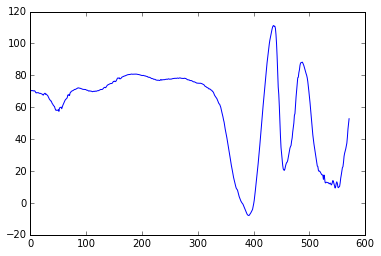

In [38]:
time_stamps = np.arange(len(all_samples))
pb.plot(time_stamps, X[40,:])
#print len(bone_map)

## Example of one output GP with some joint signal

<function matplotlib.pyplot.colorbar>

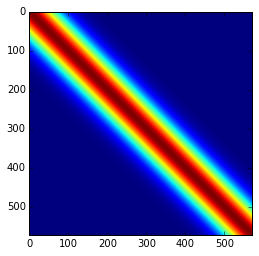

In [54]:
d = 1          # input dimension
var = 10.       # variance
theta = 50.0 
k = GPy.kern.RBF(d, variance=var, lengthscale=theta)
input_t = time_stamps
input_t = input_t[:,None]
#input_t = np.matrix(time_stamps)
#input_t = np.transpose(input_t)
C = k.K(input_t)
plt.imshow(C)
plt.colorbar

 /Users/juangilopez/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning:covariance is not positive-semidefinite.


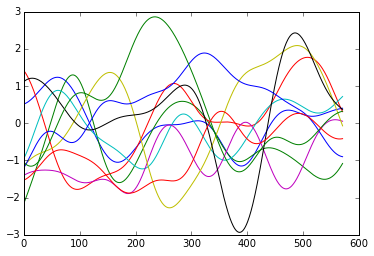

In [53]:
for i in xrange(10):
    y_sample = np.random.multivariate_normal(mean=np.zeros(input_t.shape[0]), cov=C)
    plt.plot(input_t.flatten(), y_sample.flatten())